# Property graph of things

Graph composed of nodes and edges.

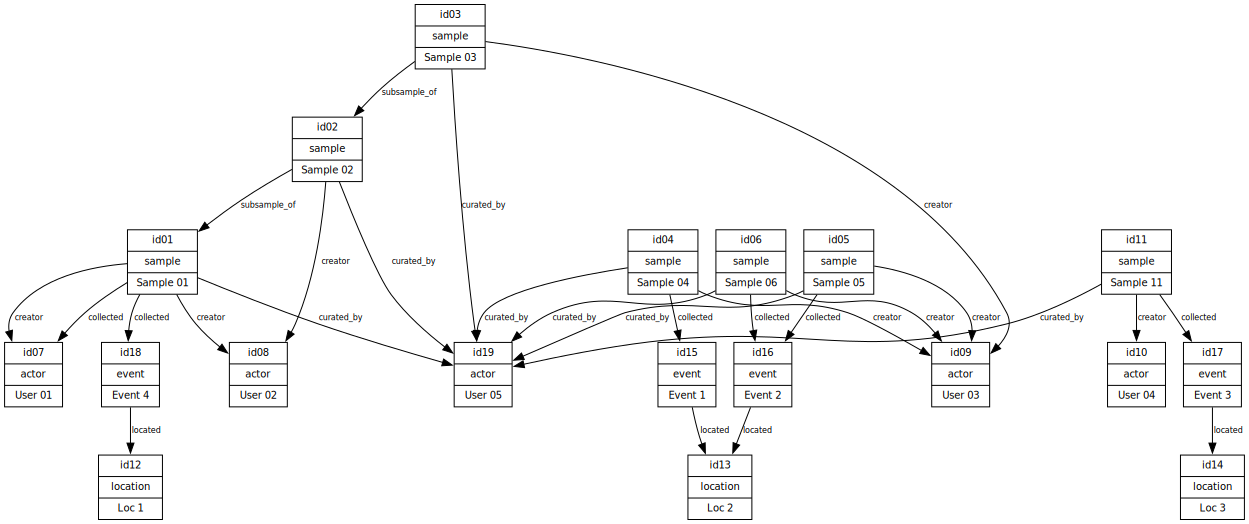

In [1]:
import psycopg
import graphviz

DB = psycopg
CNSTR = "dbname=thingtest user=vieglais"

def execute(commands):
    with DB.connect(CNSTR) as cn:
        with cn.cursor() as csr:
            for s in commands:
                csr.execute(s)
                cn.commit()

sql = [
"DROP TABLE IF EXISTS relation;",
"DROP TABLE IF EXISTS thing;",
"""CREATE TABLE thing (
    id VARCHAR PRIMARY KEY,
    ttype VARCHAR,
    name VARCHAR,
    properties JSONB NOT NULL DEFAULT '{}'::jsonb
);""", 
"""CREATE TABLE relation (
    id int PRIMARY KEY,
    s VARCHAR REFERENCES thing(id),
    o VARCHAR REFERENCES thing(id),
    p VARCHAR,
    properties JSONB NOT NULL DEFAULT '{}'::jsonb
);""",
"""INSERT INTO thing VALUES 
  ('id01', 'sample', 'Sample 01', '{}'::jsonb),
  ('id02', 'sample', 'Sample 02', '{}'::jsonb),
  ('id03', 'sample', 'Sample 03', '{}'::jsonb),
  ('id04', 'sample', 'Sample 04', '{}'::jsonb),
  ('id05', 'sample', 'Sample 05', '{}'::jsonb),
  ('id06', 'sample', 'Sample 06', '{}'::jsonb),
  ('id07', 'actor', 'User 01', '{}'::jsonb),
  ('id08', 'actor', 'User 02', '{}'::jsonb),
  ('id09', 'actor', 'User 03', '{}'::jsonb),
  ('id10', 'actor', 'User 04', '{}'::jsonb),
  ('id11', 'sample', 'Sample 11', '{}'::jsonb),
  ('id12', 'location', 'Loc 1', '{"x":-130.2,"y":37.5}'::jsonb),
  ('id13', 'location', 'Loc 2', '{"x":-150.0,"y":27.5}'::jsonb),
  ('id14', 'location', 'Loc 3', '{"x":25.0,"y":30.5}'::jsonb),
  ('id15', 'event', 'Event 1', '{}'::jsonb),
  ('id16', 'event', 'Event 2', '{}'::jsonb),
  ('id17', 'event', 'Event 3', '{}'::jsonb),
  ('id18', 'event', 'Event 4', '{}'::jsonb),
  ('id19', 'actor', 'User 05', '{}'::jsonb);
""",
"""INSERT INTO relation VALUES 
  (0, 'id01', 'id07', 'creator'),
  (1, 'id01', 'id08', 'creator'),
  (2, 'id02', 'id08', 'creator'),
  (3, 'id03', 'id09', 'creator'),
  (4, 'id04', 'id09', 'creator'),
  (5, 'id05', 'id09', 'creator'),
  (6, 'id06', 'id09', 'creator'),
  (7, 'id02', 'id01', 'subsample_of'),
  (8, 'id03', 'id02', 'subsample_of'),
  (9, 'id11', 'id10', 'creator'),
  (10, 'id18', 'id12', 'located'),
  (11, 'id15', 'id13', 'located'),
  (12, 'id16', 'id13', 'located'),
  (13, 'id06', 'id16', 'collected'),
  (14, 'id17', 'id14', 'located'),
  (15, 'id04', 'id15', 'collected'),
  (16, 'id05', 'id16', 'collected'),
  (17, 'id11', 'id17', 'collected'),
  (18, 'id01', 'id07', 'collected'),
  (19, 'id01', 'id19', 'curated_by'),
  (20, 'id02', 'id19', 'curated_by'),  
  (21, 'id03', 'id19', 'curated_by'),  
  (22, 'id04', 'id19', 'curated_by'),  
  (23, 'id05', 'id19', 'curated_by'),  
  (24, 'id06', 'id19', 'curated_by'),
  (25, 'id11', 'id19', 'curated_by'),
  (26, 'id01', 'id18', 'collected'); 
"""
]
execute(sql)

def doquery(sql, *args):
    with DB.connect(CNSTR) as cn:
        with cn.cursor() as csr:
            result = csr.execute(sql, *args).fetchall()
    return result

def show_graph(nlights=[], elights=[]):
    nodes = doquery("SELECT id, ttype, name FROM thing;")
    dst = [
        "digraph {", 
        "node [shape=record, fontname=\"JetBrains Mono\", fontsize=10];",
        "edge [fontname=\"JetBrains Mono\", fontsize=8]"
    ]
    for node in nodes:
        color = ''
        if node[0] in nlights:
            color = ',color=red'
        dst.append(f"{node[0]} [label=\"" + "{" + f"{node[0]}|{node[1]}|{node[2]}" + "}\"" + color + "]")
    rels = doquery("SELECT id, s, p, o FROM relation")
    for r in rels:
        color = ''
        if r[0] in elights:
            color = ', color=red'
        dst.append(f"{r[1]} -> {r[3]} [label=\"{r[2]}\"" + color + "]")
    dst.append("}")
    #print("\n".join(dst))
    return graphviz.Source("\n".join(dst))

def sgraph(rows, hcols=[], ecols=[]):
    nh = []
    eh = []
    for row in rows:
        for c in hcols:
            nh.append(row[c])
        for c in ecols:
            eh.append(row[c])
    return show_graph(nlights=nh, elights=eh)

show_graph()

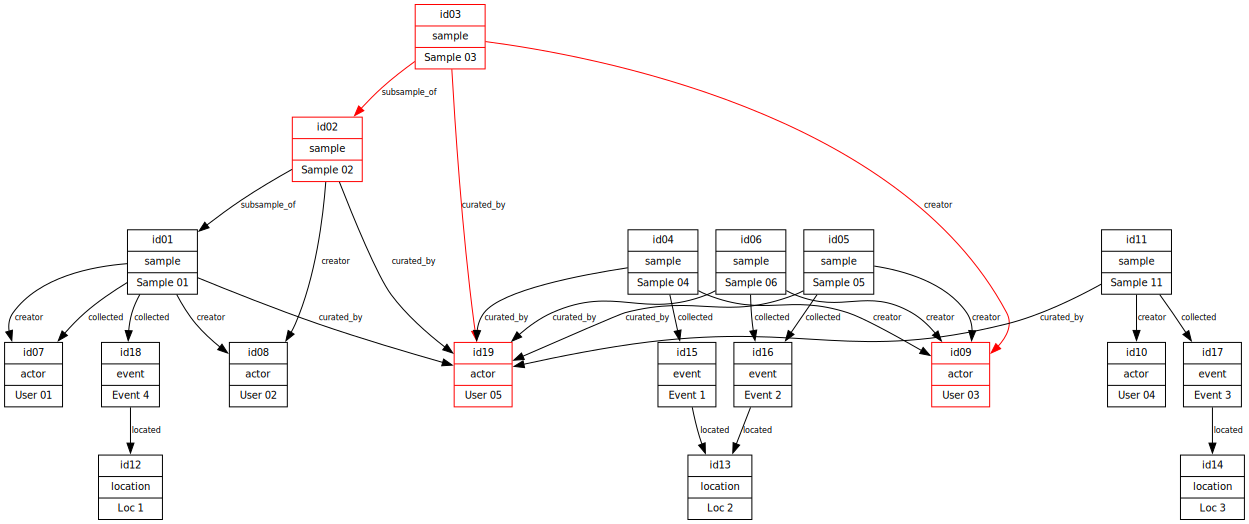

In [4]:
# Select things immediately reated to sample id03.
# Note this does not traverse to next level relations 
# such as the full sample lineage

# As a procedure
fq = """CREATE OR REPLACE FUNCTION node_immediate_components(src_id VARCHAR) 
RETURNS TABLE (
    a VARCHAR,
    b VARCHAR,
    r INT
)
AS $$
BEGIN
RETURN QUERY SELECT 
    src.id AS a,
    dst.id AS b,
    rel.id as r
FROM thing src
    JOIN relation rel ON src.id = rel.s
    JOIN thing dst ON rel.o = dst.id
WHERE src.id = src_id;
END; $$
LANGUAGE PLPGSQL;
"""
#execute([fq, ])
#sgraph(doquery("SELECT * from node_immediate_components(%s);", ['id03']), hcols=[0,1], ecols=[2])

# As plain SQL
rq = """SELECT 
    src.id AS a,
    dst.id AS b,
    rel.id as r
FROM thing src
    JOIN relation rel ON src.id = rel.s
    JOIN thing dst ON rel.o = dst.id
WHERE src.id = %s;
"""
sgraph(doquery(rq,['id03']), hcols=[0,1], ecols=[2])


('id01', 'sample', 0, 'creator', 'id07', 'actor', ['id01'], [0])
('id01', 'sample', 1, 'creator', 'id08', 'actor', ['id01'], [1])
('id01', 'sample', 18, 'collected', 'id07', 'actor', ['id01'], [18])
('id01', 'sample', 19, 'curated_by', 'id19', 'actor', ['id01'], [19])
('id01', 'sample', 26, 'collected', 'id18', 'event', ['id01'], [26])
('id18', 'event', 10, 'located', 'id12', 'location', ['id01', 'id18'], [26, 10])


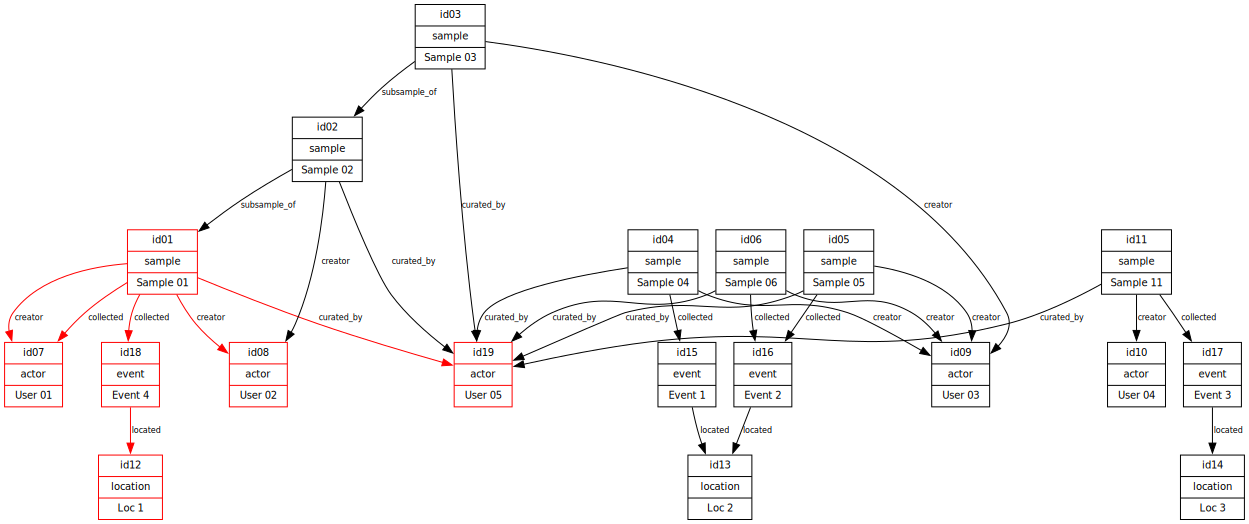

In [7]:
# Select the graph of items related to idxx, including any parent samples
#
# This function retrieves the current state of a node given it's identifier 
# and a list of predicates of interest.
#
# Connected resources are followed to construct the graph of entities that 
# combined provide the state of the identified resource.
#
# Note that resources the reference the identified resource are not included, since
# resources that reference the identified resource are not part of the state 
# of that resource. For example, a sample exists independently of any subsamples, 
# though a subsample state depends on its origin.
#
# as a procedure
fq = """CREATE OR REPLACE FUNCTION components_of(
  src_id VARCHAR, 
  predicates VARCHAR[], 
  max_depth int default 100
) 
RETURNS TABLE (
    a VARCHAR,
    atype VARCHAR,
    r INT,
    predicate VARCHAR,
    b VARCHAR,
    btype VARCHAR,
    path VARCHAR[],
    rpath INT[]
)
AS $$
BEGIN
RETURN QUERY WITH RECURSIVE full_thing(a_id, a_type, rel_id, predicate, b_id, depth, path, rpath) 
AS (
  SELECT 
    t.id AS a_id,
    t.ttype as a_type,
    r.id AS rel_id,
    r.p,
    r.o as b_id, 
    1 as depth,
    array[t.id] as path,
    array[r.id] as rpath
  FROM thing t
  JOIN relation r ON r.s = t.id
  WHERE t.id = src_id AND r.p = ANY(predicates)
  UNION ALL
  SELECT
    t.id,
    t.ttype,
    r.id,
    r.p,
    r.o,
    ft.depth + 1 as depth,
    ft.path || t.id as path,
    ft.rpath || r.id as path
  FROM thing t, full_thing ft 
  JOIN relation r on r.s = ft.b_id
  WHERE 
    t.id = ft.b_id 
    AND r.p = ANY(predicates)
    AND (t.id <> ALL(ft.path))
    AND ft.depth <= max_depth
)
SELECT ft.a_id, ft.a_type, ft.rel_id, ft.predicate, ft.b_id, t.ttype, ft.path, ft.rpath
FROM full_thing ft
JOIN thing t ON ft.b_id=t.id;
END; $$
LANGUAGE PLPGSQL;
"""
#execute([fq])
#rows = doquery(
#    "SELECT * FROM components_of(%s, %s)", 
#    ['id01', ['creator','collected','located','curated_by', 'subsample_of']]
#)

#as plain sql
rq = """WITH RECURSIVE full_thing(a_id, a_type, rel_id, predicate, b_id, depth, path, rpath) 
AS (
  SELECT 
    t.id AS a_id,
    t.ttype as a_type,
    r.id AS rel_id,
    r.p,
    r.o as b_id, 
    1 as depth,
    array[t.id] as path,
    array[r.id] as rpath
  FROM thing t
  JOIN relation r ON r.s = t.id
  WHERE t.id = %(src_id)s AND r.p = ANY(%(predicates)s)   -- src_id
  UNION ALL
  SELECT
    t.id,
    t.ttype,
    r.id,
    r.p,
    r.o,
    ft.depth + 1 as depth,
    ft.path || t.id as path,
    ft.rpath || r.id as path
  FROM thing t, full_thing ft 
  JOIN relation r on r.s = ft.b_id
  WHERE 
    t.id = ft.b_id 
    AND r.p = ANY(%(predicates)s)                        -- predicates
    AND (t.id <> ALL(ft.path))
    AND ft.depth <= %(max_depth)s                       -- max_depth
)
SELECT ft.a_id, ft.a_type, ft.rel_id, ft.predicate, ft.b_id, t.ttype, ft.path, ft.rpath
FROM full_thing ft
JOIN thing t ON ft.b_id=t.id;
"""

rows = doquery(rq, {
    "src_id":'id01', 
    "predicates": ['creator','collected','located','curated_by', 'subsample_of'], 
    "max_depth": 100
    }
)
for row in rows:
    print(row)
sgraph(rows, hcols=[0,4], ecols=[2])


('id18', 10)
('id01', 26)
('id02', 7)
('id03', 8)


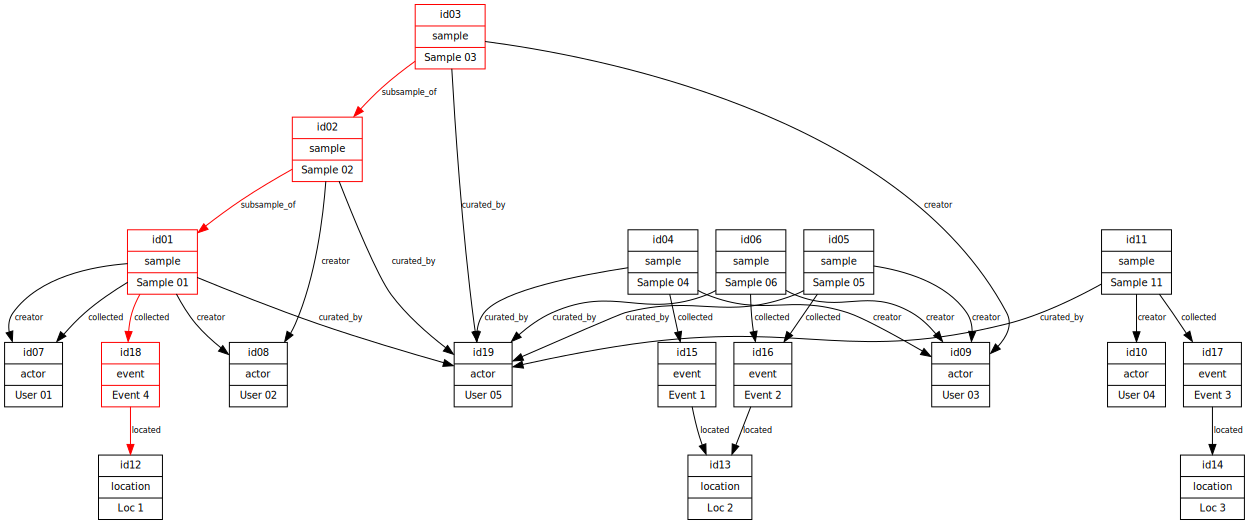

In [11]:
# Retrieve the derivaties of the specified resource.
#
# The function returns the graph of all entities that reference the specified 
# resource by predicates in the provided predicate list.
fq="""CREATE OR REPLACE FUNCTION referenced_by(
  src_id VARCHAR, 
  predicates VARCHAR[], 
  max_depth int default 100
) 
RETURNS TABLE (
    a VARCHAR,
    r INT
)
AS $$
BEGIN RETURN QUERY WITH RECURSIVE full_thing(a_id, rel_id, depth, path) 
AS (
  SELECT 
    r.s AS a_id,
    r.id AS rel_id,
    1 as depth,
    array[r.s] as path
  FROM relation r
  WHERE r.o = src_id AND r.p = ANY(predicates)
  UNION ALL
  SELECT
    r.s,
    r.id,
    ft.depth + 1 as depth,
    path || r.s as path
  FROM relation r, full_thing ft
  WHERE 
    r.o = ft.a_id 
    AND r.p = ANY(predicates)
    AND (r.s <> ALL(ft.path))
    AND ft.depth <= max_depth

)
SELECT ft.a_id, ft.rel_id FROM full_thing ft;
END; $$
LANGUAGE PLPGSQL;
"""
execute([fq,])
rows = doquery("SELECT * FROM referenced_by(%s, %s)",['id12', ['located', 'collected', 'subsample_of']])
for row in rows:
    print(row)
sgraph(rows,hcols=[0,], ecols=[1,])

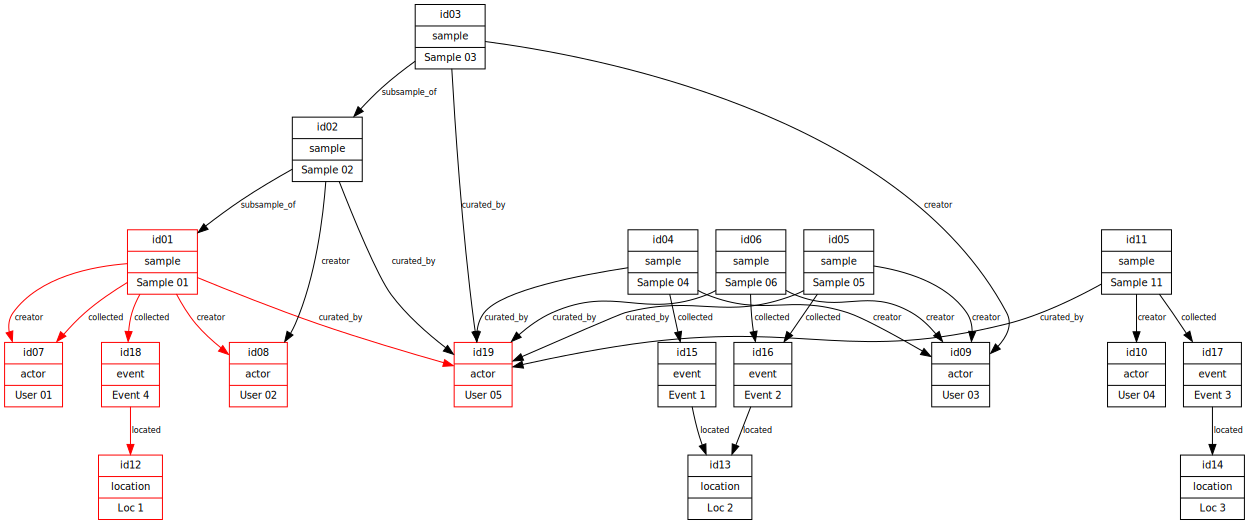

In [6]:
# Select the graph of items related to id01, excluding subsamples
q = """
WITH RECURSIVE full_thing(a_id, a_type, rel_id, predicate, b_id) 
AS (
  SELECT 
    t.id AS a_id,
    t.ttype as a_type,
    r.id AS rel_id,
    r.p,
    r.o as b_id
  FROM thing t
  JOIN relation r ON r.s = t.id
  WHERE t.id = 'id01' AND r.p != 'subsample_of'
  UNION ALL
  SELECT
    t.id,
    t.ttype,
    r.id,
    r.p,
    r.o
  FROM thing t, full_thing ft 
  JOIN relation r on r.s = ft.b_id
  WHERE t.id = ft.b_id
)
SELECT ft.a_id, ft.a_type, ft.rel_id, ft.predicate, ft.b_id, t.ttype 
FROM full_thing ft
JOIN thing t ON ft.b_id=t.id;
"""
sgraph(doquery(q), hcols=[0,4], ecols=[2])


('id02', 'sample', 7, 'subsample_of', 'id01', 'sample', ['subsample_of', 'subsample_of'])
('id03', 'sample', 8, 'subsample_of', 'id02', 'sample', ['subsample_of'])
('id01', 'sample', 18, 'collected', 'id07', 'actor', ['subsample_of', 'subsample_of', 'collected'])
('id18', 'event', 10, 'located', 'id12', 'location', ['subsample_of', 'subsample_of', 'collected', 'located'])
('id01', 'sample', 26, 'collected', 'id18', 'event', ['subsample_of', 'subsample_of', 'collected'])


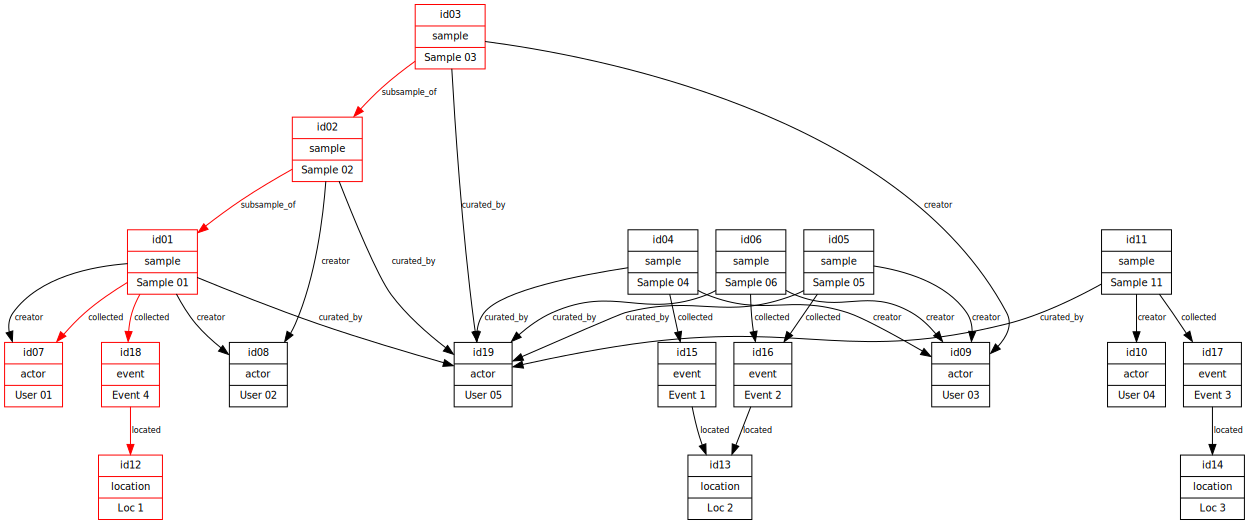

In [7]:
# Predicate paths for the walk
q = """
WITH RECURSIVE full_thing(a_id, a_type, rel_id, predicate, b_id, pp) 
AS (
  SELECT 
    t.id AS a_id,
    t.ttype as a_type,
    r.id AS rel_id,
    r.p,
    r.o as b_id,
    ARRAY[r.p] as pp
  FROM thing t
  JOIN relation r ON r.s = t.id
  WHERE t.id = 'id03' and r.p in ('subsample_of', 'collected', 'located')
  UNION ALL
  SELECT
    t.id,
    t.ttype,
    r.id,
    r.p,
    r.o,
    ft.pp || r.p
  FROM thing t, full_thing ft 
  JOIN relation r on r.s = ft.b_id
  WHERE t.id = ft.b_id  and r.p in ('subsample_of', 'collected', 'located')
)
SELECT ft.a_id, ft.a_type, ft.rel_id, ft.predicate, ft.b_id, t.ttype, ft.pp 
FROM full_thing ft
JOIN thing t ON ft.b_id=t.id;
"""
rows = doquery(q)
for row in rows:
    print(row)
    #print(", ".join([str(c) for c in row]))
sgraph(rows, hcols=[0,4], ecols=[2,])

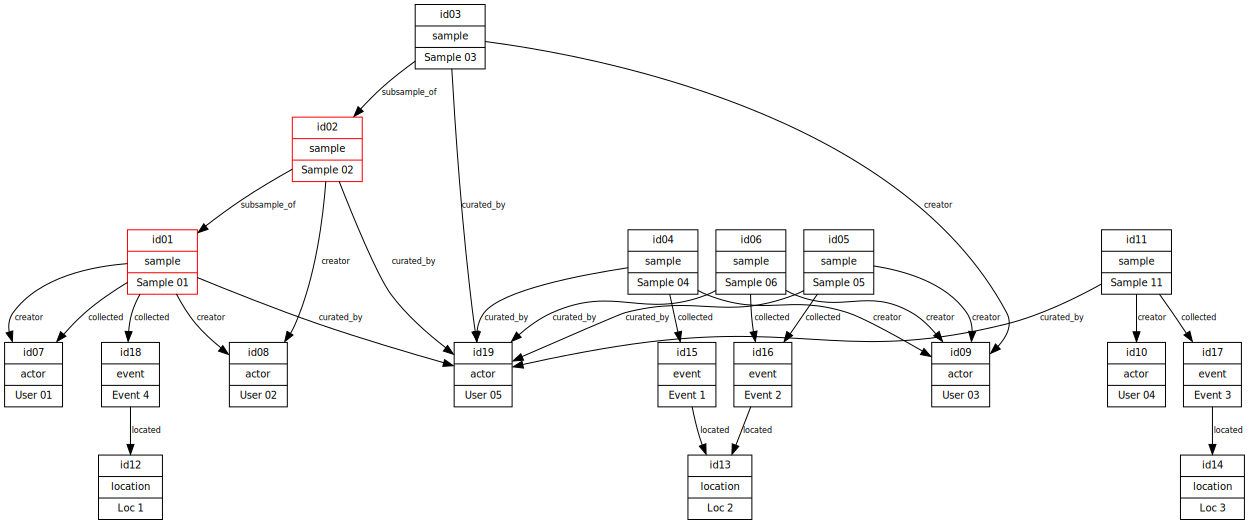

In [8]:
# All things that have been subsampled
q = """
SELECT DISTINCT o FROM relation WHERE relation.p = 'subsample_of';
"""
sgraph(doquery(q), hcols=[0,])

('id02', 7)
('id03', 8)


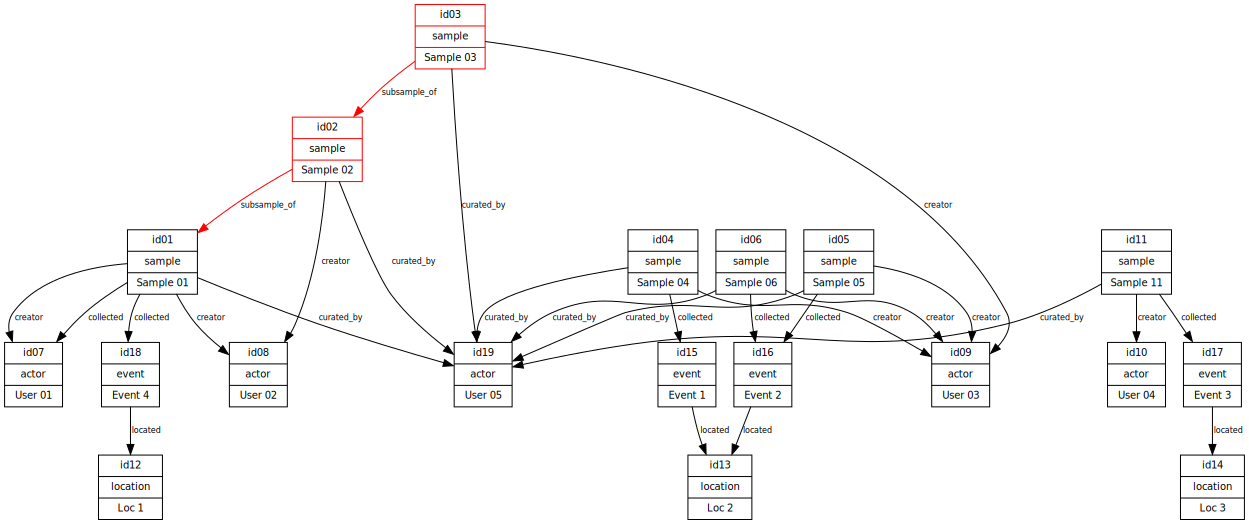

In [9]:
# All subsamples of id01
q = """
WITH RECURSIVE full_thing(a_id, rel_id) 
AS (
  SELECT 
    r.s AS a_id,
    r.id AS rel_id
  FROM relation r
  WHERE r.o = 'id01' and r.p = 'subsample_of'
  UNION ALL
  SELECT
    r.s,
    r.id
  FROM relation r, full_thing ft
  WHERE r.o = ft.a_id
)
SELECT * FROM full_thing ft;
"""
rows = doquery(q)
for row in rows: 
  print(row)
sgraph(rows, hcols=[0,], ecols=[1,])

('id01', 26, 'sample')
('id02', 7, 'sample')
('id03', 8, 'sample')


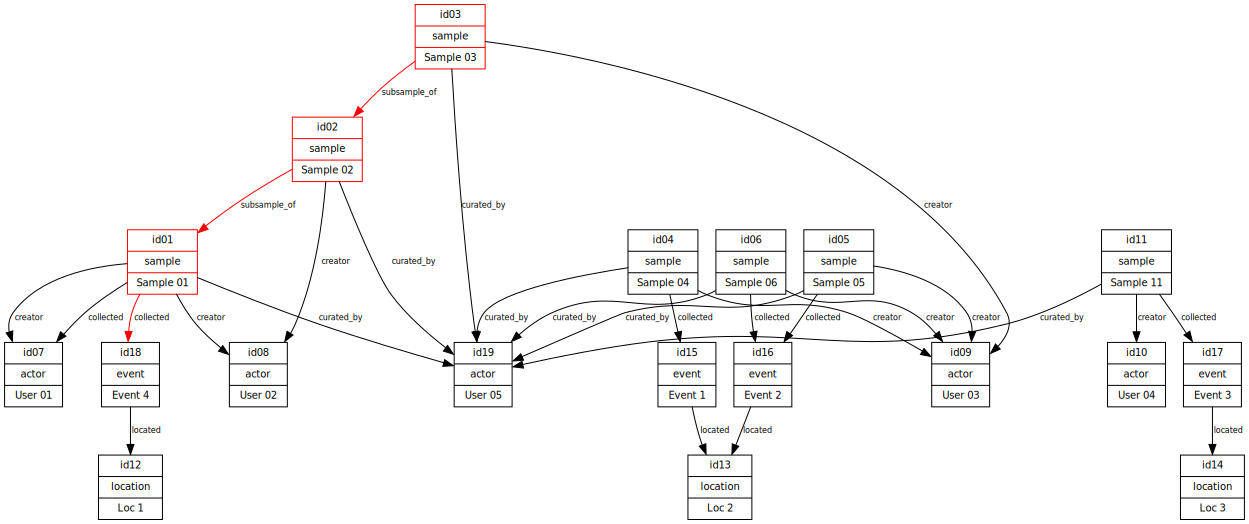

In [10]:
# All samples taken from loc 2
q = """
WITH RECURSIVE full_thing(a_id, rel_id) 
AS (
  SELECT 
    r.s AS a_id,
    r.id AS rel_id
  FROM relation r
  WHERE r.o = 'id12' and r.p IN ('located', 'collected','subsample_of')
  UNION ALL
  SELECT
    r.s,
    r.id
  FROM relation r, full_thing ft
  WHERE r.o = ft.a_id
)
SELECT ft.a_id, ft.rel_id, t.ttype FROM full_thing ft
JOIN thing t ON t.id=ft.a_id
WHERE t.ttype = 'sample';
"""
rows = doquery(q)
for row in rows: 
  print(row)
sgraph(rows, hcols=[0,], ecols=[1,])
